# Cucumber or courgette?

Whilst following the fast.ai course, Jeremy mentioned that a student had trained a cumcumber vs courgette classifier. I thought that was cool, so I'm going to give it a try using some of the tools from Lessons 1 & 2.

As much as this makes me uncomfortable, Jeremy assures me that `from fastai import *` will work perfectly fine and is designed that way. Who am I to argue?

In [1]:
from fastai.vision import *

Following the instructions from url, I went to google images and used this code snippet 
```javascript
urls=Array.from(document.querySelectorAll('.rg_i')).map(el=> el.hasAttribute('data-src')?el.getAttribute('data-src'):el.getAttribute('data-iurl'));
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));
```
to download some images of cucumbers and courgettes and uploaded them onto my Google Cloud instance.

In [2]:
path = Path('/home/jupyter/my-datasets/cucumbers-courgettes')

In [14]:
path.ls()

[PosixPath('/home/jupyter/my-datasets/cucumbers-courgettes/cucumbers'),
 PosixPath('/home/jupyter/my-datasets/cucumbers-courgettes/courgettes'),
 PosixPath('/home/jupyter/my-datasets/cucumbers-courgettes/cucumbers-urls.txt'),
 PosixPath('/home/jupyter/my-datasets/cucumbers-courgettes/courgettes-urls.txt'),
 PosixPath('/home/jupyter/my-datasets/cucumbers-courgettes/models')]

In [4]:
download_images(path/'cucumbers-urls.txt', path/'cucumbers', max_pics=300)

In [5]:
download_images(path/'courgettes-urls.txt', path/'courgettes', max_pics=300)

Now remove any images that can't be opened

In [6]:
classes = ['cucumbers', 'courgettes']

In [7]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

cucumbers


courgettes


## View data

In [8]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, valid_pct=0.2, ds_tfms=get_transforms(), 
                                  size=224, num_workers=4).normalize(imagenet_stats)

In [9]:
data.classes

['courgettes', 'cucumbers']

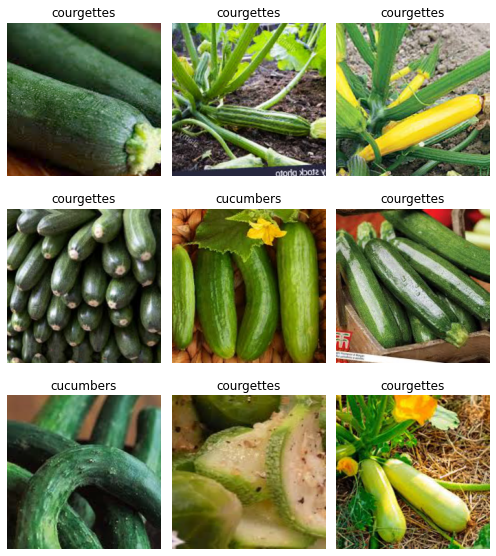

In [10]:
data.show_batch(rows=3, figsize=(7,8))

Data are pretty dirty, but let's try and train a model and see how it goes.

In [11]:
p1 = path/'courgettes'
len(p1.ls())

300

In [12]:
p2 = path/'cucumbers'
len(p2.ls())

240

## Train model

In [13]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [15]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.155623,0.983839,0.407407,00:03
1,0.883772,1.007379,0.314815,00:02
2,0.722104,0.674083,0.185185,00:02
3,0.644653,0.585365,0.185185,00:02


In [16]:
learn.save('stage-1')

In [17]:
learn.unfreeze()

In [18]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Hmmm not sure why `valid_loss` is `#na#` but let's roll with it

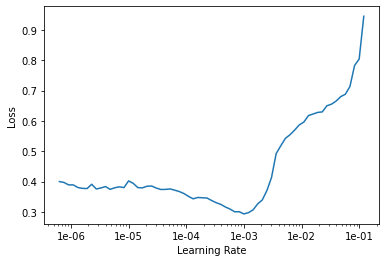

In [19]:
learn.recorder.plot()

In [20]:
learn.fit_one_cycle(2, max_lr=slice(1e-4, 3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.468839,0.828966,0.231481,00:02
1,0.429596,0.728474,0.185185,00:02


In [21]:
learn.save('stage-2')

# Interpretation

In [23]:
learn.load('stage-2');

In [24]:
interp = ClassificationInterpretation.from_learner(learn)

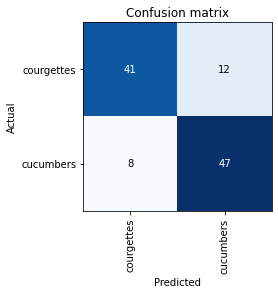

In [25]:
interp.plot_confusion_matrix()

That's not bad at all given how dirty the data were!

## Cleaning up

Some of the top losses are likely due to bad validation data rather than the model being bad.

Use `ImageCleaner` to prune the top losses away to remove photos that don't belong.